In [3]:
##### Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import tifffile as tiff

In [6]:
##### Open Data from Experimental Results
IntensityExperimental = np.load('MACRO_Experimental.npy')

##### Open Data from Simulation Results and Convert Units to uE m-2 s-1
IntensitySimulationWattsPerCM2 = np.load('MACRO_Simulation.npy')
IntensitySimulationWattsPerM2 = np.rot90(IntensitySimulationWattsPerCM2*10000, 3)
EnergyPerMolePhots = 2.55e-1 #[J]
IntensitySimulationuEins = 1.6968*IntensitySimulationWattsPerM2/(EnergyPerMolePhots) # First number is to scale the inensities so that total power matches power meter reading

#### Crop and Resize Image to Match Experimental Image
## Crop
IntensitySimulationuEinsCropped = IntensitySimulationuEins[157:352, 128:415]

## Resize 
scale_percent = (IntensityExperimental.shape[1]/IntensitySimulationuEinsCropped.shape[1])
width = int(IntensitySimulationuEinsCropped.shape[1] * scale_percent)
height = int(IntensitySimulationuEinsCropped.shape[0] * scale_percent)
dim = (width, height)
resized = cv2.resize(IntensitySimulationuEinsCropped, dim, interpolation = cv2.INTER_AREA)
IntensitySimulationuEinsCroppedResized = resized[0:608, 0:968]

#Remove Background where values are low
IntensitySimulationuEinsCroppedResized[IntensitySimulationuEinsCroppedResized < 3000] = 0 
IntensityExperimental[IntensityExperimental < 3000] = 0 

In [7]:
## Calculate Total Power from Both Intensity Images

PixelAreaConjugatedToSamplePlane = 5.0955674e-10 #[m2]

## Experimental
PowerDistributionImage = IntensityExperimental*PixelAreaConjugatedToSamplePlane*EnergyPerMolePhots
TotalPower = np.sum(PowerDistributionImage)
print("Total Power Experimental: " + str(TotalPower*1000) + " mW")


## Simulated
PowerDistributionImage = IntensitySimulationuEinsCroppedResized*PixelAreaConjugatedToSamplePlane*EnergyPerMolePhots
TotalPower = np.sum(PowerDistributionImage)
print("Total Power Simulated: " + str(TotalPower*1000) + " mW")

Total Power Experimental: 258.1723452477261 mW
Total Power Simulated: 241.9988061795939 mW


(-0.5, 967.5, 607.5, -0.5)

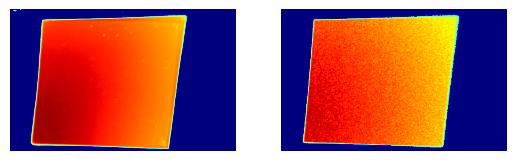

In [28]:
##### Display Images Side-by-Side
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')

ax[0].imshow(IntensityExperimental, vmin=0, vmax=7000, cmap='jet', aspect='equal')
ax[1].imshow(IntensitySimulationuEinsCroppedResized, vmin=0, vmax=7000, cmap='jet', aspect='equal')
ax[0].axis('off')
ax[1].axis('off')

In [13]:
## Determine Max Gradient Direction

def maxGradientAngle(image, centerOfRotation):
    
    Gradients = []
    
    for i in range(180):

        rot_mat = cv2.getRotationMatrix2D(centerOfRotation, i, 1.0)
        result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

        x = np.linspace(0,399,400)
        y = result[300-200:300+200, 400]

        #find line of best fit
        a, b = np.polyfit(x, y, 1)

        Gradients.append(a)

    return Gradients.index(max(Gradients))
    
    

print("Experimental - Angle of Gradient: ", maxGradientAngle(IntensityExperimental, (400,300)))
print("Simulation - Angle of Gradient: ", maxGradientAngle(IntensitySimulationuEinsCroppedResized, (400,300)))

Experimental - Angle of Gradient:  65
Simulation - Angle of Gradient:  68
